# Coinmap Analysis

In [84]:
# dependencies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests as req
import json
import datetime
import scipy.stats as stats

In [2]:
# store file path
path = os.path.join('BTC-USD.csv')

# store in dataframe
btc_df = pd.read_csv(path)
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-02-01,20.410000,34.520000,18.000000,33.380001,33.380001,41087388
1,2013-03-01,33.380001,95.699997,32.919998,93.029999,93.029999,123005256
2,2013-03-31,93.029999,266.000000,50.009998,139.229996,139.229996,544645777
3,2013-04-30,139.229996,140.059998,79.000000,128.820007,128.820007,233751764
4,2013-05-31,128.820007,130.100006,88.000000,97.510002,97.510002,112735944


In [3]:
# convert string to datetime object
btc_df["Date"] = pd.to_datetime(btc_df.Date)

# format date
btc_df["Date"] = btc_df["Date"].dt.strftime("%Y-%m")

# drop duplicate dates & keep last 
btc_df = btc_df.drop_duplicates(['Date'], keep='last')
    
btc_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2013-02,20.410000,34.520000,18.000000,33.380001,33.380001,41087388
2,2013-03,93.029999,266.000000,50.009998,139.229996,139.229996,544645777
3,2013-04,139.229996,140.059998,79.000000,128.820007,128.820007,233751764
4,2013-05,128.820007,130.100006,88.000000,97.510002,97.510002,112735944
5,2013-06,97.510002,111.650002,65.419998,106.209999,106.209999,100174821


# Coinmap API requests

In [4]:
# base url
url = "https://coinmap.org/api/v1/venues/"

# parameters
params = {'before': '2017-12-01'}

# run request and print response
response = req.get(url, params=params).json()
print(json.dumps(response, indent = 4,sort_keys=True))

# store response in dataframe
coinmap_df = pd.DataFrame(response['venues'])

{
    "venues": [
        {
            "category": "atm",
            "created_on": 1465943680,
            "id": 8225,
            "lat": 50.1220639499942,
            "lon": -5.53289830684662,
            "name": "One And All"
        },
        {
            "category": "default",
            "created_on": 1397211665,
            "id": 42,
            "lat": 60.1605345,
            "lon": 24.9390492,
            "name": "Belle Modeste"
        },
        {
            "category": "grocery",
            "created_on": 1394219130,
            "id": 15,
            "lat": 48.4377466,
            "lon": -123.3124115,
            "name": "Slaters Meats"
        },
        {
            "category": "default",
            "created_on": 1422120857,
            "id": 33,
            "lat": 50.0658333,
            "lon": 14.3588965,
            "name": "kaktusy eshop"
        },
        {
            "category": "food",
            "created_on": 1370785480,
            "id": 3,
            "l

In [5]:
# create empty list
formatted_date = []

# Reformat the 'created_on' Date
for date in coinmap_df['created_on']:
    newdate = datetime.datetime.fromtimestamp(date)
    newdate2 = newdate.strftime('%Y-%m')
    formatted_date.append(newdate2) 
    
# store in new column    
coinmap_df['date(YYYY-MM)'] = formatted_date

coinmap_df.head()

,category,created_on,id,lat,lon,name,date(YYYY-MM)
0,atm,1465943680,8225,50.122064,-5.532898,One And All,2016-06
1,default,1397211665,42,60.160534,24.939049,Belle Modeste,2014-04
2,grocery,1394219130,15,48.437747,-123.312411,Slaters Meats,2014-03
3,default,1422120857,33,50.065833,14.358897,kaktusy eshop,2015-01
4,food,1370785480,3,51.549378,-0.059379,Pembury Tavern,2013-06


# Coinmap Venue Category 

In [86]:
category_counts = coinmap_df['category'].value_counts()

category_df = pd.DataFrame(category_counts)
category_df = category_df.reset_index()
category_df = category_df.rename(columns={'category':'count', 'index':'category'})
category_df

,category,count
0,default,5971
1,shopping,1648
2,food,1050
3,atm,568
4,lodging,504
5,cafe,286
6,nightlife,206
7,sports,176
8,attraction,159
9,grocery,134


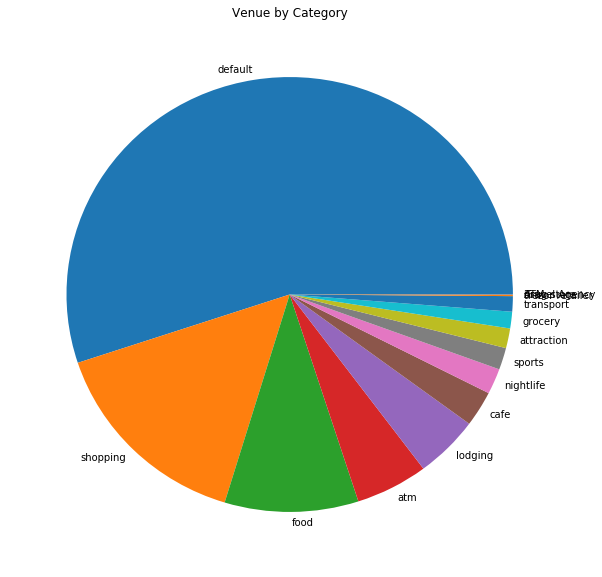

In [89]:
labels = category_df['category']
sizes = category_df['count']

fig = plt.figure(figsize=[10, 10])
ax = fig.add_subplot(111)

pie_wedge_collection = ax.pie(sizes, labels=labels, labeldistance=1.05);

ax.set_title('Venue by Category')
plt.savefig('venue_categories.png')

plt.show()

In [7]:
# group by date and create new dataframe
df_group_date = coinmap_df['date(YYYY-MM)'].value_counts()
venue_count_df = pd.DataFrame({'Venues': df_group_date})
df2 = venue_count_df.reset_index()

# rename column
venue_count_df = df2.rename(columns={'index':'Date'})

# sort date
df_summary = venue_count_df.sort_values(by=['Date'])

df_summary.head()

,Date,Venues
57,2013-02,1
56,2013-03,2
53,2013-04,35
54,2013-05,18
55,2013-06,13


In [10]:
# calculate cumulative sum
df_summary['Cumulative Sum'] = df_summary.Venues.cumsum()

df_summary = pd.merge(df_summary, btc_df, on='Date')

df_summary.head()

,Date,Venues,Cumulative Sum,Open,High,Low,Close,Adj Close,Volume
0,2013-02,1,1,20.410000,34.520000,18.000000,33.380001,33.380001,41087388
1,2013-03,2,3,93.029999,266.000000,50.009998,139.229996,139.229996,544645777
2,2013-04,35,38,139.229996,140.059998,79.000000,128.820007,128.820007,233751764
3,2013-05,18,56,128.820007,130.100006,88.000000,97.510002,97.510002,112735944
4,2013-06,13,69,97.510002,111.650002,65.419998,106.209999,106.209999,100174821


# Number of New Venues Accepting Bitcoin and Adjusted Close Price

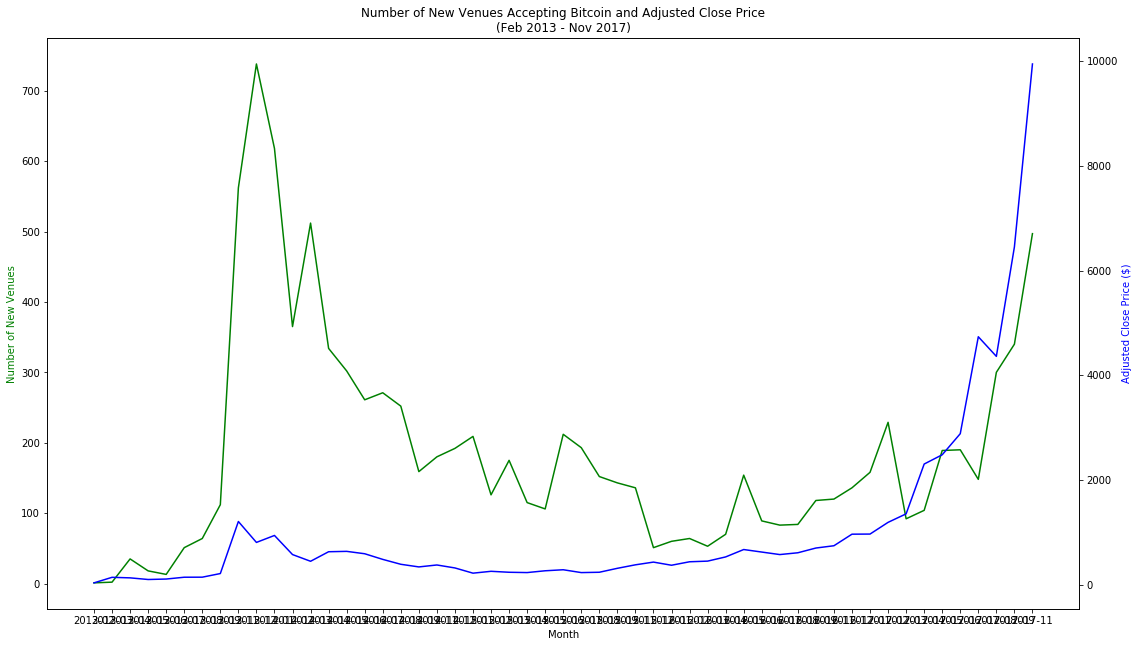

In [90]:
# plot
x = df_summary['Date']
y1 = df_summary['Venues']
y2 = df_summary['Adj Close']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'b-')
ax1.set_xlabel('Month')
ax2.set_ylabel('Adjusted Close Price ($)', color='b')
ax1.set_ylabel('Number of New Venues', color='g')
plt.title('Number of New Venues Accepting Bitcoin and Adjusted Close Price\n(Feb 2013 - Nov 2017)')
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_new_venues_price.png')
plt.show()

In [39]:
print('Linear Regression between Number of New Venues and Adjusted Close Price per Month')
x = df_summary['Venues']
y = df_summary['Adj Close']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('p_value:', p_value,'r_value:', r_value,'std_err:', std_err)

Linear Regression between Number of New Venues and Adjusted Close Price per Month
p_value: 0.0107718858126 r_value: 0.347564018099 std_err: 1.44817564508


# Number of New Venues Accepting Bitcoin and Volume

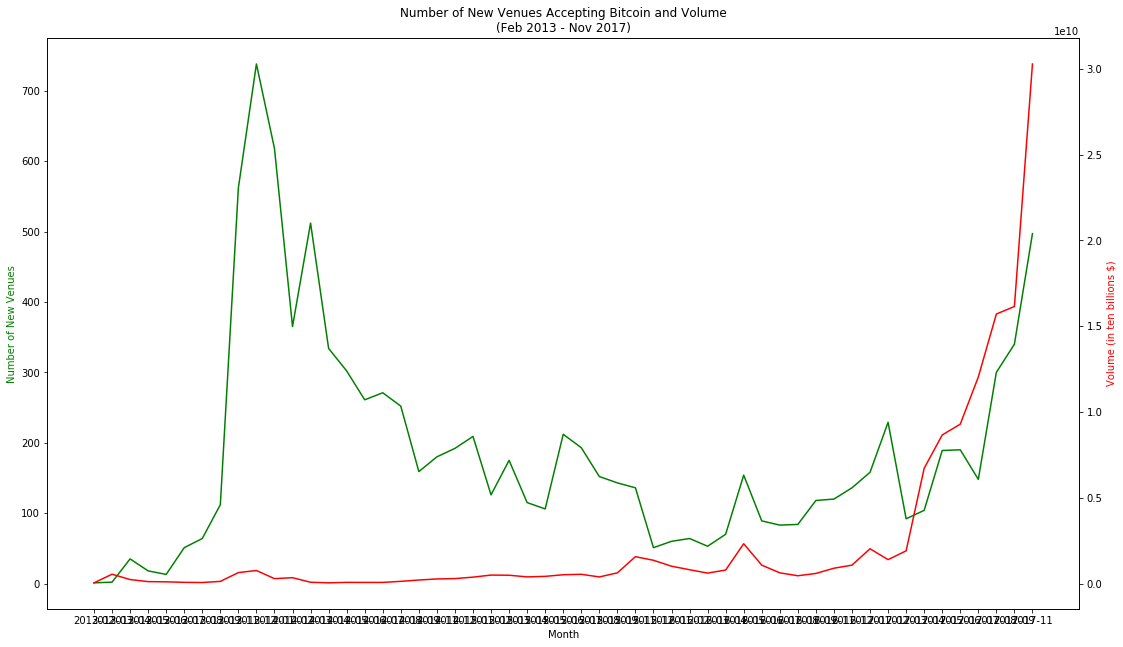

In [91]:
# plot
x = df_summary['Date']
y1 = df_summary['Venues']
y2 = df_summary['Volume']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'r-')
ax1.set_xlabel('Month')
ax2.set_ylabel('Volume (in ten billions $)', color='r')
ax1.set_ylabel('Number of New Venues', color='g')
plt.title('Number of New Venues Accepting Bitcoin and Volume\n(Feb 2013 - Nov 2017)')
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_new_venues_volume.png')
plt.show()

In [38]:
print('Linear Regression between Number of New Venues and Volume per Month')
x = df_summary['Venues']
y = df_summary['Volume']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('p_value:', p_value,'r_value:', r_value,'std_err:', std_err)

Linear Regression between Number of New Venues and Volume per Month
p_value: 0.0531607912403 r_value: 0.267123366076 std_err: 4574121.46135


# Total Number of Venues Accepting Bitcoin and Volume

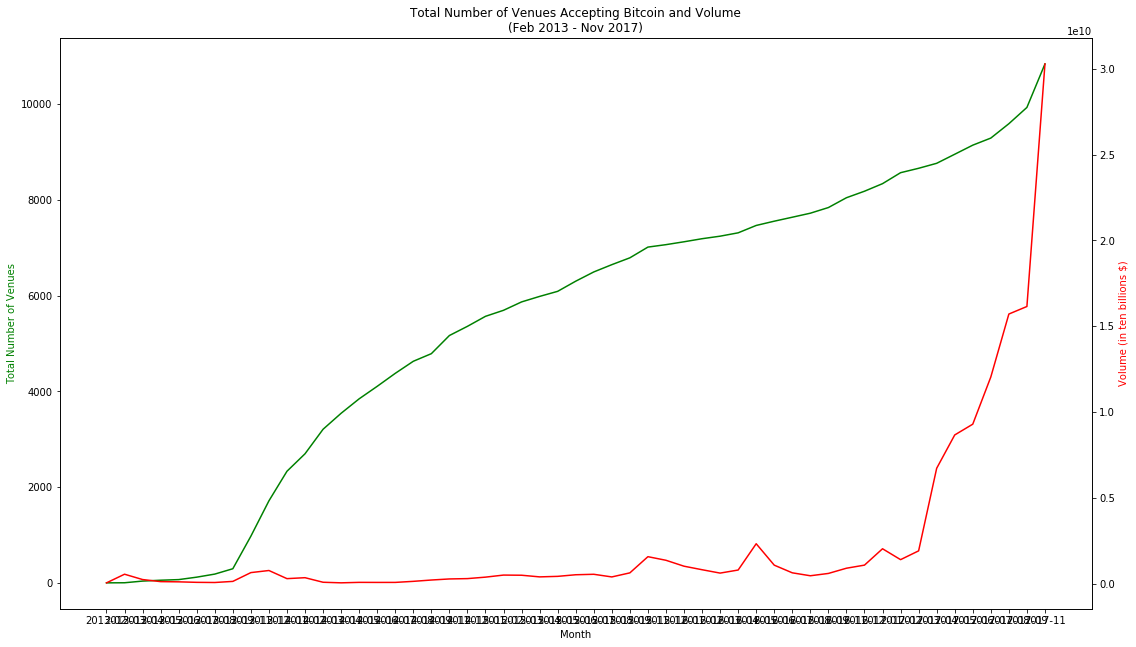

In [92]:
# plot
x = df_summary['Date']
y1 = df_summary['Cumulative Sum']
y2 = df_summary['Volume']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'r-')
ax1.set_xlabel('Month')
ax2.set_ylabel('Volume (in ten billions $)', color='r')
ax1.set_ylabel('Total Number of Venues', color='g')
plt.title('Total Number of Venues Accepting Bitcoin and Volume\n(Feb 2013 - Nov 2017)')
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_total_venues_volume.png')
plt.show()

In [37]:
print('Linear Regression between Total Venues and Volume per Month')
x = df_summary['Cumulative Sum']
y = df_summary['Volume']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('p_value:', p_value,'r_value:', r_value,'std_err:', std_err)

Linear Regression between Total Venues and Volume per Month
p_value: 5.86665678389e-05 r_value: 0.523035212426 std_err: 206246.127474


# Total Number of Venues Accepting Bitcoin and Adjusted Close Price

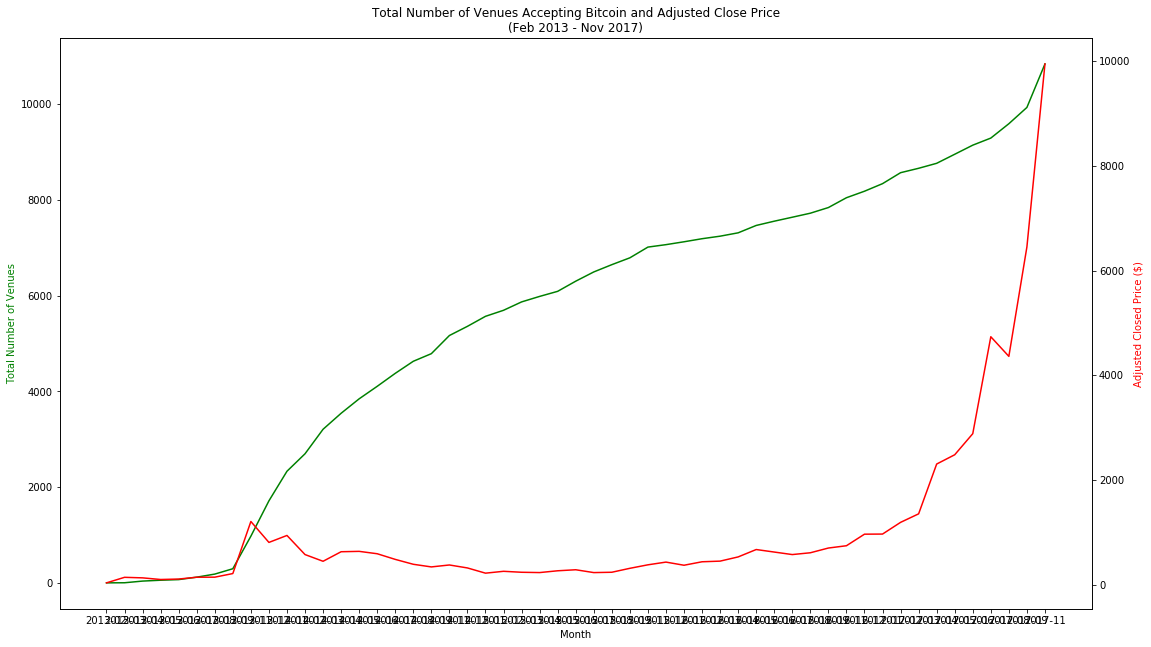

In [93]:
# plot
x = df_summary['Date']
y1 = df_summary['Cumulative Sum']
y2 = df_summary['Adj Close']
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(x, y1, 'g-')
ax2.plot(x, y2, 'r-')
ax1.set_xlabel('Month')
ax2.set_ylabel('Adjusted Closed Price ($)', color='r')
ax1.set_ylabel('Total Number of Venues', color='g')
plt.title('Total Number of Venues Accepting Bitcoin and Adjusted Close Price\n(Feb 2013 - Nov 2017)')
plt.xticks(rotation=90)
fig.set_size_inches(18.5, 10.5)
plt.savefig('bitcoin_total_venues_price.png')
plt.show()

In [58]:
print('Linear Regression between Number of New Venues and Adjusted Close Price per Month')
x = df_summary['Cumulative Sum']
y = df_summary['Adj Close']
slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
print('p_value:', p_value,'r_value:', r_value,'std_err:', std_err)

Linear Regression between Number of New Venues and Adjusted Close Price per Month
p_value: 6.88103662446e-05 r_value: 0.518856487684 std_err: 0.0673097748738


In [59]:
r_value_summary = [{'Coinmap Venues': 'Cumulative Sum', 'Adjusted Close Price (r value)': 0.518856487684, 'Adjusted Close Price (p value)': '6.88103662446e-05' , 'Volume (r value)': 0.523035212426, 'Volume (p value)': '5.86665678389e-05'},
                  {'Coinmap Venues': 'New Venues', 'Adjusted Close Price (r value)': 0.347564018099, 'Adjusted Close Price (p value)': 0.0107718858126 , 'Volume (r value)': 0.267123366076 , 'Volume (p value)': 0.0531607912403 }]

df = pd.DataFrame(r_value_summary)
df= df[['Coinmap Venues', 'Adjusted Close Price (r value)', 'Adjusted Close Price (p value)', 'Volume (r value)', 'Volume (p value)']]

df.head()

,Coinmap Venues,Adjusted Close Price (r value),Adjusted Close Price (p value),Volume (r value),Volume (p value)
0,Cumulative Sum,0.518856,6.88103662446e-05,0.523035,5.86665678389e-05
1,New Venues,0.347564,0.0107719,0.267123,0.0531608
